**Amber Yandow<br>
Full-time Data Science<br> 
4/10/19 - 5:00pm<br>
Brandon Lewis<br>
https://amberlynnyandow.github.io/**


# Module 2 Final Project Objectives

For this project, you'll be working with the Northwind database--a free, open-source dataset created by Microsoft containing data from a fictional company. Here's the schema for the Northwind database:

<img src='Northwind_ERD.png'>

The goal of this project is to test your ability to gather information from a real-world database and use your knowledge of statistical analysis and hypothesis testing to generate analytical insights that can be of value to the company. 



## Business Requirements
**The goal of this project is to use statistics to determine the probability that a given hypothesis is true.<br>
The relevant hypotheseses:**


## Importing useful tools

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import inspect

## Data Aquisition  

In [2]:
engine = create_engine("sqlite:///Northwind_small.sqlite")
inspector = inspect(engine)
print(inspector.get_table_names())

['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In [3]:
def get_columns_info(col_name): #function that returns well-formatted table info 
    cols_list = inspector.get_columns(col_name)
    print('Table Name: {}'.format(col_name))
    print('')
    
    for column in cols_list:
        print('Name: {} \t Type: {}'.format(column['name'], column['type']))

test = get_columns_info('Order')
print(test)


Table Name: Order

Name: Id 	 Type: INTEGER
Name: CustomerId 	 Type: VARCHAR(8000)
Name: EmployeeId 	 Type: INTEGER
Name: OrderDate 	 Type: VARCHAR(8000)
Name: RequiredDate 	 Type: VARCHAR(8000)
Name: ShippedDate 	 Type: VARCHAR(8000)
Name: ShipVia 	 Type: INTEGER
Name: Freight 	 Type: DECIMAL
Name: ShipName 	 Type: VARCHAR(8000)
Name: ShipAddress 	 Type: VARCHAR(8000)
Name: ShipCity 	 Type: VARCHAR(8000)
Name: ShipRegion 	 Type: VARCHAR(8000)
Name: ShipPostalCode 	 Type: VARCHAR(8000)
Name: ShipCountry 	 Type: VARCHAR(8000)
None


## Inquiry 1: Do discounts have a statistically significant effect on the number of products customers order? If so, what levels? 

**$H_O$: Discounts have no effect on the number of products customers order.<br> 
$H_a$: Discounts have an effect on the number of products customers order.<br> 
$\alpha$ = 0.05**

## Data Cleaning 

In [4]:
df1 = pd.read_sql_query('''SELECT * FROM OrderDetail;''', engine)
print('Rows and Columns:\n', df1.shape,'\n\n', '-------------------------\n\n')
print( df1.info(), '\n\n', '-------------------------\n\n')
print('Dataframe Head\n', df1.head())

Rows and Columns:
 (2155, 6) 

 -------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB
None 

 -------------------------


Dataframe Head
          Id  OrderId  ProductId  UnitPrice  Quantity  Discount
0  10248/11    10248         11       14.0        12       0.0
1  10248/42    10248         42        9.8        10       0.0
2  10248/72    10248         72       34.8         5       0.0
3  10249/14    10249         14       18.6         9       0.0
4  10249/51    10249         51       42.4        40       0.0


In [5]:
'''We do not need Id and OrderId, lets drop those to decrease any noise.'''

df1 = df1.drop(['Id', 'OrderId'], axis=1)
df1.head()

,ProductId,UnitPrice,Quantity,Discount
0,11,14.0,12,0.0
1,42,9.8,10,0.0
2,72,34.8,5,0.0
3,14,18.6,9,0.0
4,51,42.4,40,0.0


In [6]:
df1.Discount.value_counts() #What are the discount amounts and quantities? 

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

In [7]:
'''There is no missing data to deal with. No null values and the datatypes seem appropriate.
   However, there is insufficient data records for 1%, 2%, 3%, 4% and 6%. We should eliminate those.'''
 
new_discount = (df1.Discount == 0.00) | (df1.Discount == 0.05) | (df1.Discount == 0.10) | (df1.Discount == 0.15) | (df1.Discount == 0.20) | (df1.Discount == 0.25)
df1_new = df1.loc[new_discount]
df1_new.Discount.value_counts()


0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
Name: Discount, dtype: int64

## Data Exploration

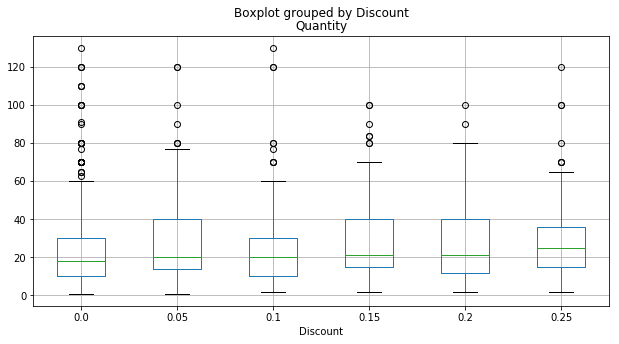

In [8]:
df1_new.boxplot('Quantity', by='Discount', figsize=(10,5)); #How many outliers do we have? 

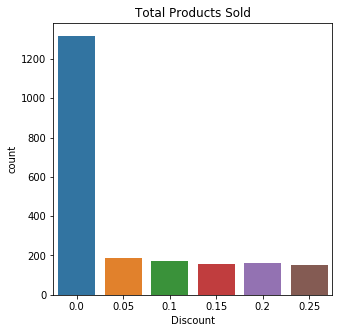

In [9]:
fig, ax = plt.subplots(figsize=(5,5)) #Use for analysis of which discount is best #create a box plot instead just discounts
sns.countplot(x='Discount',
              data=df1_new)
plt.title('Total Products Sold')
plt.show()



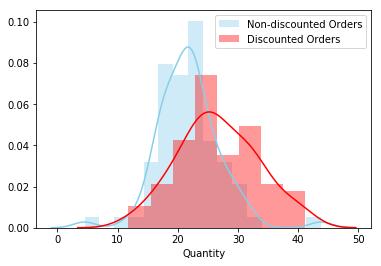

The average amount of items ordered with a discount is 26.72 items. The average amount of items ordered without a discount is 21.81 items


In [10]:
discount = df1_new[df1_new['Discount']!=0].groupby('ProductId')['Quantity'].mean()
no_discount = df1_new[df1_new['Discount']==0].groupby('ProductId')['Quantity'].mean()

sns.distplot( no_discount , color="skyblue", label="Non-discounted Orders")
sns.distplot( discount , color="red", label="Discounted Orders")
plt.legend()
 
plt.show()
print("The average amount of items ordered with a discount is {} items. The average amount of items ordered without a discount is {} items".format(round(discount.values.mean(),2), round(no_discount.values.mean(),2)))

**The average number of discounted items sold is higher than the average number of non-discounted items sold. Therefore, there is enough evidence to proceed with a hypothesis test.**

## Data Modeling
#### We will use a one-tailed t-test because we want to know if the average number of discounted products ordered is higher than the average number of non-discounted products orered. Our $\alpha$ = 0.05. If p < $\alpha$, we reject the null hypothesis.
$H_O$: Discounts have no effect on the number of products customers order.<br> 
$H_a$: Discounts have an effect on the number of products customers order.<br> 


In [11]:
'''T-tests are used in hypothesis testing because they compare two means;
   they can tell you the level of significance the differences have;
   and the probability that the difference could've happened by chance.
   The Welch's T test does not assume the samples have equal variances but 
   it does assume normality'''

from scipy.stats import shapiro #checking orders without discounts for normality 
no_discount = np.array(no_discount)
mu = np.mean(no_discount)
sig = np.std(no_discount)
no_discount = np.random.normal(mu, sig, 1317)
stat, p = shapiro(no_discount)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = .05
if p > alpha:
    print('Non-discounted data looks normal')
else:
    print('Non-discounted data does not look normal')

Statistics=0.999, p=0.867
Non-discounted data looks normal


In [12]:
from scipy.stats import shapiro #checking orders with discounts for normality 
discount = np.array(discount)
mu = np.mean(discount)
sig = np.std(discount)
discount = np.random.normal(mu, sig, 1317)
stat, p = shapiro(discount)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = .05
if p > alpha:
    print('Discounted data looks normal')
else:
    print('Discounted data does not look normal')

Statistics=0.999, p=0.558
Discounted data looks normal


**Both the discounted and non-discounted datasets appear normal so we can move onto the Welch's T-test.** 

In [13]:
'''If a statistical difference exists, effect size will measure the magnitude of that difference.
   Cohens D is a popular means of measuring effect size.'''

def Cohen_d(group1, group2):
    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return abs(d)

In [14]:
from scipy import stats 
no_discount = df1_new[df1_new['Discount']==0]['Quantity'] #control
discount = df1_new[df1_new['Discount']!=0]['Quantity']#experimental 

'''It is important to keep the discounted items and non-discounted items seperate. We will
refer to the non-discounted items as the control. This prevents any undue influence.'''

t_stat, p = stats.ttest_ind(no_discount, discount)#welchs t-test 
d = Cohen_d(discount, no_discount)
print('p_value =', p)
print('Reject null hypothesis') if p < 0.05 else print('Failed to reject null hypothesis')
print("Cohen's d =", d)


p_value = 1.7401995278127614e-11
Reject null hypothesis
Cohen's d = 0.29970787209408895


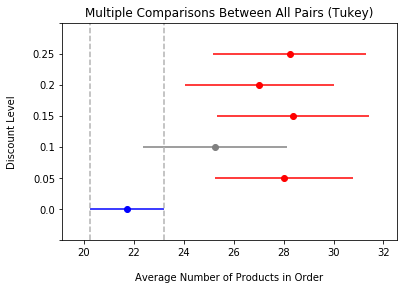

In [15]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd #Comparing bewtween discounts 
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df1_new['Quantity'], df1_new['Discount'])
mc_results = mc.tukeyhsd()
mc_results.plot_simultaneous(comparison_name=0.0, figsize=(6,4), 
                             ylabel='Discount Level\n', xlabel='\nAverage Number of Products in Order');

## Results

**The calculated p-value for our Welch's test was less than our level of significance. So, we are able to reject the null hypothesis and show that discounts do effect the quantity of orders purchased. However, according to our D statistic the effect is small.** 

**The Tukey test tells us, specifically, which groups means differ. Cohen's D could also measure the mean differences. Here, we can see that all discount levels significantly effect order quantity except for the 10% discount(grey line).**

## Does demand for products in each category significantly differ by month? 

#### To answer this question I will perform eight ANOVA tests(one for each category). An analysis of variance determines whether there is a difference between the means of two or more groups. ANOVA require the same assumptions as our TTest but we will be using an F statistic to accept or reject the null hypothesis. The F statistic is robust to violations of normality and homogeneity of variance. So, for the following tests we will not test normality or variance. 

#### The test statistic F follows an F-distribution with $q$ - 1 degrees of freedom, with $q$ being the number of groups. 

#### $H_O$: There is not a statistically significant difference for demand of product monthly
#### $H_a$: There is a statistically significant difference for demand of product monthly 

#### If F < $\alpha$(0.05) then we reject the null hypothesis 

In [16]:
import statsmodels.api as sm #Imports for ANOVA
import statsmodels.formula.api as smf

In [17]:
df_category = pd.read_sql_query('''SELECT * FROM Category;''', engine)#What are the product descriptions? 
df_category.head(10)

,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


## df2 = Category 1 = Beverages 

In [18]:
df2 = pd.read_sql_query('''

                                SELECT O.OrderDate, OD.Quantity, OD.Discount, CategoryId FROM [Order] AS O
                                JOIN OrderDetail AS OD
                                ON O.Id = OD.OrderId
                                JOIN Product
                                ON Product.Id = OD.ProductId
                                WHERE Product.CategoryId = 1

''',engine)
print('Rows and Columns:\n', df2.shape,'\n\n', '********************\n\n')
print( df2.info(), '\n\n', '********************\n\n')
print('Dataframe Head\n', df2.head())

Rows and Columns:
 (404, 4) 

 ********************


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 4 columns):
OrderDate     404 non-null object
Quantity      404 non-null int64
Discount      404 non-null float64
CategoryId    404 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 12.7+ KB
None 

 ********************


Dataframe Head
     OrderDate  Quantity  Discount  CategoryId
0  2012-07-10        42      0.00           1
1  2012-07-11        15      0.15           1
2  2012-07-12        20      0.00           1
3  2012-07-16         6      0.00           1
4  2012-07-17        50      0.20           1


### Grouping by month 

In [19]:
df2.OrderDate = pd.to_datetime(df2.OrderDate)
df2['Month'] = df2.OrderDate.dt.month
df2.groupby('Month').mean()


,Quantity,Discount,CategoryId
Month,,,
1,21.636364,0.062500,1.0
2,25.707317,0.060976,1.0
3,27.372549,0.058824,1.0
4,24.727273,0.075455,1.0
5,20.884615,0.067308,1.0
6,20.866667,0.040000,1.0
7,22.185185,0.066667,1.0
8,20.636364,0.051515,1.0
9,21.857143,0.026190,1.0


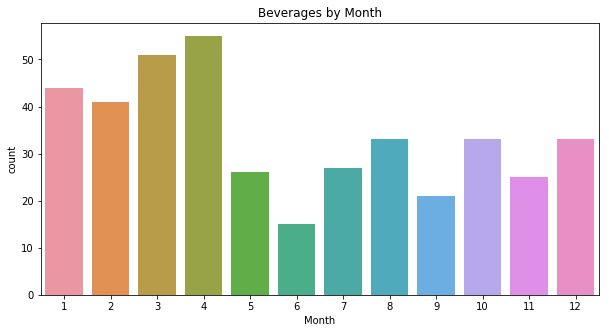

In [20]:
fig, ax = plt.subplots(figsize=(10,5)) 
sns.countplot(x='Month',
              data=df2)
plt.title('Beverages by Month')
plt.show()

In [21]:
formula = 'Quantity ~ C(Month)'
lm = smf.ols(formula, df2).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq     df         F    PR(>F)
C(Month)    1885.923081   11.0  0.457102  0.928559
Residual  147029.502662  392.0       NaN       NaN


## df3 = Category 2 = Condiments 

In [22]:
df3 = pd.read_sql_query('''

                                SELECT O.OrderDate, OD.Quantity, OD.Discount, CategoryId FROM [Order] AS O
                                JOIN OrderDetail AS OD
                                ON O.Id = OD.OrderId
                                JOIN Product
                                ON Product.Id = OD.ProductId
                                WHERE Product.CategoryId = 2

''',engine)
print('Rows and Columns:\n', df3.shape,'\n\n', '********************\n\n')
print( df3.info(), '\n\n', '********************\n\n')
print('Dataframe Head\n', df3.head())

Rows and Columns:
 (216, 4) 

 ********************


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 4 columns):
OrderDate     216 non-null object
Quantity      216 non-null int64
Discount      216 non-null float64
CategoryId    216 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 6.8+ KB
None 

 ********************


Dataframe Head
     OrderDate  Quantity  Discount  CategoryId
0  2012-07-08        15      0.15           2
1  2012-07-08        20      0.00           2
2  2012-07-15        12      0.00           2
3  2012-07-16        15      0.00           2
4  2012-07-17        65      0.20           2


In [23]:
df3.OrderDate = pd.to_datetime(df3.OrderDate) #grouping by month 
df3['Month'] = df3.OrderDate.dt.month
df3.groupby('Month').mean()

,Quantity,Discount,CategoryId
Month,,,
1,25.714286,0.066667,2.0
2,35.894737,0.052632,2.0
3,21.120000,0.062000,2.0
4,21.363636,0.050000,2.0
5,21.117647,0.054118,2.0
6,15.833333,0.008333,2.0
7,29.266667,0.116667,2.0
8,21.176471,0.044118,2.0
9,25.538462,0.038462,2.0


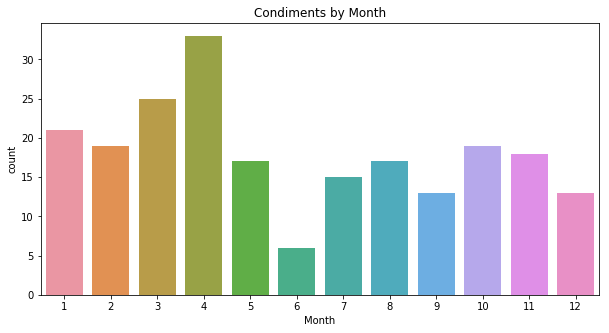

In [24]:
fig, ax = plt.subplots(figsize=(10,5)) #visualization
sns.countplot(x='Month',
              data=df3)
plt.title('Condiments by Month')
plt.show()

In [25]:
formula = 'Quantity ~ C(Month)'
lm = smf.ols(formula, df3).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq     df         F    PR(>F)
C(Month)   4371.021881   11.0  1.018466  0.431231
Residual  79592.811452  204.0       NaN       NaN


## df4 = Category 3 = Confections

In [26]:
df4 = pd.read_sql_query('''

                                SELECT O.OrderDate, OD.Quantity, OD.Discount, CategoryId FROM [Order] AS O
                                JOIN OrderDetail AS OD
                                ON O.Id = OD.OrderId
                                JOIN Product
                                ON Product.Id = OD.ProductId
                                WHERE Product.CategoryId = 3

''',engine)
print('Rows and Columns:\n', df4.shape,'\n\n', '********************\n\n')
print( df4.info(), '\n\n', '********************\n\n')
print('Dataframe Head\n', df4.head())

Rows and Columns:
 (334, 4) 

 ********************


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 4 columns):
OrderDate     334 non-null object
Quantity      334 non-null int64
Discount      334 non-null float64
CategoryId    334 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 10.5+ KB
None 

 ********************


Dataframe Head
     OrderDate  Quantity  Discount  CategoryId
0  2012-07-09        40      0.05           3
1  2012-07-10        40      0.00           3
2  2012-07-12        35      0.00           3
3  2012-07-16        25      0.00           3
4  2012-07-18        10      0.00           3


In [27]:
df4.OrderDate = pd.to_datetime(df4.OrderDate) #grouping by month 
df4['Month'] = df4.OrderDate.dt.month
df4.groupby('Month').mean()

,Quantity,Discount,CategoryId
Month,,,
1,24.043478,0.072826,3.0
2,22.552632,0.065789,3.0
3,26.627907,0.041860,3.0
4,28.689655,0.036207,3.0
5,21.363636,0.044091,3.0
6,17.833333,0.108333,3.0
7,21.666667,0.057143,3.0
8,22.954545,0.065909,3.0
9,20.633333,0.041667,3.0


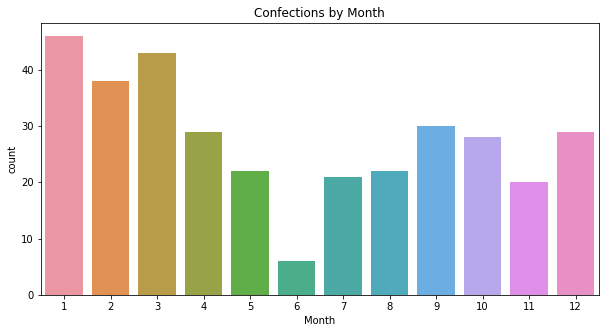

In [28]:
fig, ax = plt.subplots(figsize=(10,5)) #visualization
sns.countplot(x='Month',
              data=df4)
plt.title('Confections by Month')
plt.show()

In [29]:
formula = 'Quantity ~ C(Month)'
lm = smf.ols(formula, df4).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq     df         F    PR(>F)
C(Month)   2255.979195   11.0  0.680812  0.756744
Residual  96999.793260  322.0       NaN       NaN


## df5 = Category 4 = Dairy Products

In [30]:
df5 = pd.read_sql_query('''

                                SELECT O.OrderDate, OD.Quantity, OD.Discount, CategoryId FROM [Order] AS O
                                JOIN OrderDetail AS OD
                                ON O.Id = OD.OrderId
                                JOIN Product
                                ON Product.Id = OD.ProductId
                                WHERE Product.CategoryId = 4

''',engine)
print('Rows and Columns:\n', df5.shape,'\n\n', '********************\n\n')
print( df5.info(), '\n\n', '********************\n\n')
print('Dataframe Head\n', df5.head())

Rows and Columns:
 (366, 4) 

 ********************


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 4 columns):
OrderDate     366 non-null object
Quantity      366 non-null int64
Discount      366 non-null float64
CategoryId    366 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 11.5+ KB
None 

 ********************


Dataframe Head
     OrderDate  Quantity  Discount  CategoryId
0  2012-07-04        12      0.00           4
1  2012-07-04         5      0.00           4
2  2012-07-09        25      0.05           4
3  2012-07-09        40      0.00           4
4  2012-07-10        20      0.00           4


In [31]:
df5.OrderDate = pd.to_datetime(df5.OrderDate) #grouping by month 
df5['Month'] = df5.OrderDate.dt.month
df5.groupby('Month').mean()

,Quantity,Discount,CategoryId
Month,,,
1,29.722222,0.047222,4.0
2,28.916667,0.045833,4.0
3,22.300000,0.057500,4.0
4,27.466667,0.036667,4.0
5,17.633333,0.053667,4.0
6,25.312500,0.087500,4.0
7,26.076923,0.051923,4.0
8,21.083333,0.043750,4.0
9,22.115385,0.055769,4.0


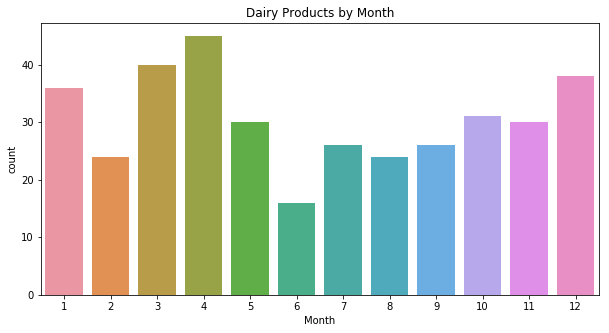

In [32]:
fig, ax = plt.subplots(figsize=(10,5)) #visualization
sns.countplot(x='Month',
              data=df5)
plt.title('Dairy Products by Month')
plt.show()

In [33]:
formula = 'Quantity ~ C(Month)'
lm = smf.ols(formula, df4).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq     df         F    PR(>F)
C(Month)   2255.979195   11.0  0.680812  0.756744
Residual  96999.793260  322.0       NaN       NaN


## df6 = Category 5 = Grains and Cereals

In [34]:
df6 = pd.read_sql_query('''

                                SELECT O.OrderDate, OD.Quantity, OD.Discount, CategoryId FROM [Order] AS O
                                JOIN OrderDetail AS OD
                                ON O.Id = OD.OrderId
                                JOIN Product
                                ON Product.Id = OD.ProductId
                                WHERE Product.CategoryId = 5

''',engine)
print('Rows and Columns:\n', df6.shape,'\n\n', '********************\n\n')
print( df6.info(), '\n\n', '********************\n\n')
print('Dataframe Head\n', df6.head())

Rows and Columns:
 (196, 4) 

 ********************


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 4 columns):
OrderDate     196 non-null object
Quantity      196 non-null int64
Discount      196 non-null float64
CategoryId    196 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 6.2+ KB
None 

 ********************


Dataframe Head
     OrderDate  Quantity  Discount  CategoryId
0  2012-07-04        10      0.00           5
1  2012-07-08         6      0.05           5
2  2012-07-08        15      0.05           5
3  2012-07-19        50      0.00           5
4  2012-07-22         2      0.00           5


In [35]:
df6.OrderDate = pd.to_datetime(df6.OrderDate) #grouping by month 
df6['Month'] = df6.OrderDate.dt.month
df6.groupby('Month').mean()

,Quantity,Discount,CategoryId
Month,,,
1,28.740741,0.025926,5.0
2,22.473684,0.050000,5.0
3,18.150000,0.060000,5.0
4,21.480000,0.026000,5.0
5,31.666667,0.053333,5.0
6,29.200000,0.050000,5.0
7,25.076923,0.050000,5.0
8,19.545455,0.004545,5.0
9,18.375000,0.050000,5.0


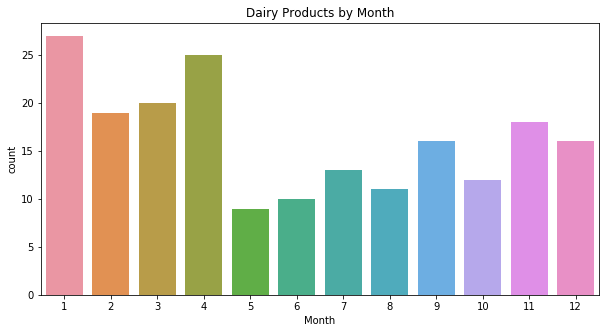

In [36]:
fig, ax = plt.subplots(figsize=(10,5)) #visualization
sns.countplot(x='Month',
              data=df6)
plt.title('Dairy Products by Month')
plt.show()

In [37]:
formula = 'Quantity ~ C(Month)'
lm = smf.ols(formula, df6).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq     df         F    PR(>F)
C(Month)   3162.048961   11.0  0.855684  0.584842
Residual  61813.073488  184.0       NaN       NaN


## df7 = Category 6 = Meat and Poultry

In [38]:
df7 = pd.read_sql_query('''

                                SELECT O.OrderDate, OD.Quantity, OD.Discount, CategoryId FROM [Order] AS O
                                JOIN OrderDetail AS OD
                                ON O.Id = OD.OrderId
                                JOIN Product
                                ON Product.Id = OD.ProductId
                                WHERE Product.CategoryId = 6

''',engine)
print('Rows and Columns:\n', df7.shape,'\n\n', '********************\n\n')
print( df7.info(), '\n\n', '********************\n\n')
print('Dataframe Head\n', df7.head())

Rows and Columns:
 (173, 4) 

 ********************


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 4 columns):
OrderDate     173 non-null object
Quantity      173 non-null int64
Discount      173 non-null float64
CategoryId    173 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 5.5+ KB
None 

 ********************


Dataframe Head
     OrderDate  Quantity  Discount  CategoryId
0  2012-07-11        21      0.15           6
1  2012-07-15        15      0.00           6
2  2012-07-25        30      0.00           6
3  2012-07-30        10      0.00           6
4  2012-08-13        15      0.25           6


In [39]:
df7.OrderDate = pd.to_datetime(df7.OrderDate) #grouping by month 
df7['Month'] = df7.OrderDate.dt.month
df7.groupby('Month').mean()

,Quantity,Discount,CategoryId
Month,,,
1,19.555556,0.088889,6.0
2,32.476190,0.064286,6.0
3,14.923077,0.053846,6.0
4,26.210526,0.071053,6.0
5,22.000000,0.083333,6.0
6,18.571429,0.021429,6.0
7,28.333333,0.038889,6.0
8,18.000000,0.054167,6.0
9,21.230769,0.057692,6.0


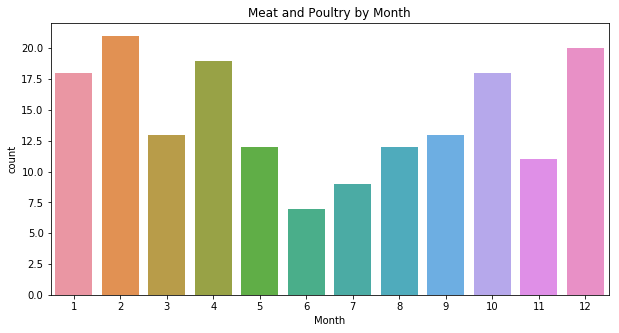

In [40]:
fig, ax = plt.subplots(figsize=(10,5)) #visualization
sns.countplot(x='Month',
              data=df7)
plt.title('Meat and Poultry by Month')
plt.show()

In [41]:
formula = 'Quantity ~ C(Month)'
lm = smf.ols(formula, df7).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq     df         F    PR(>F)
C(Month)   4989.509361   11.0  0.911979  0.530343
Residual  80076.721853  161.0       NaN       NaN


## df8 = Category 7 = Produce 

In [42]:
df8 = pd.read_sql_query('''

                                SELECT O.OrderDate, OD.Quantity, OD.Discount, CategoryId FROM [Order] AS O
                                JOIN OrderDetail AS OD
                                ON O.Id = OD.OrderId
                                JOIN Product
                                ON Product.Id = OD.ProductId
                                WHERE Product.CategoryId = 7

''',engine)
print('Rows and Columns:\n', df8.shape,'\n\n', '********************\n\n')
print( df8.info(), '\n\n', '********************\n\n')
print('Dataframe Head\n', df8.head())

Rows and Columns:
 (136, 4) 

 ********************


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 4 columns):
OrderDate     136 non-null object
Quantity      136 non-null int64
Discount      136 non-null float64
CategoryId    136 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.3+ KB
None 

 ********************


Dataframe Head
     OrderDate  Quantity  Discount  CategoryId
0  2012-07-05         9      0.00           7
1  2012-07-05        40      0.00           7
2  2012-07-08        35      0.15           7
3  2012-07-11        21      0.00           7
4  2012-07-22        15      0.00           7


In [43]:
df8.OrderDate = pd.to_datetime(df8.OrderDate) #grouping by month 
df8['Month'] = df8.OrderDate.dt.month
df8.groupby('Month').mean()

,Quantity,Discount,CategoryId
Month,,,
1,16.545455,0.050000,7.0
2,15.555556,0.011111,7.0
3,21.500000,0.004545,7.0
4,29.105263,0.028947,7.0
5,12.888889,0.075556,7.0
6,21.285714,0.085714,7.0
7,26.375000,0.050000,7.0
8,15.666667,0.038889,7.0
9,17.500000,0.025000,7.0


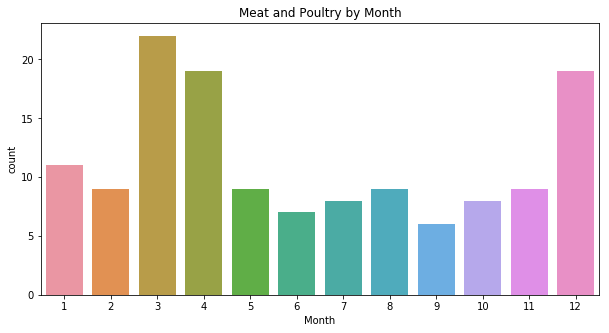

In [44]:
fig, ax = plt.subplots(figsize=(10,5)) #visualization
sns.countplot(x='Month',
              data=df8)
plt.title('Meat and Poultry by Month')
plt.show()

In [45]:
formula = 'Quantity ~ C(Month)'
lm = smf.ols(formula, df8).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                sum_sq     df         F    PR(>F)
C(Month)   4834.012843   11.0  1.318794  0.221691
Residual  41319.957745  124.0       NaN       NaN


## df9 = Category 8 = Seafood

In [46]:
df9 = pd.read_sql_query('''

                                SELECT O.OrderDate, OD.Quantity, OD.Discount, CategoryId FROM [Order] AS O
                                JOIN OrderDetail AS OD
                                ON O.Id = OD.OrderId
                                JOIN Product
                                ON Product.Id = OD.ProductId
                                WHERE Product.CategoryId = 8

''',engine)
print('Rows and Columns:\n', df9.shape,'\n\n', '********************\n\n')
print( df9.info(), '\n\n', '********************\n\n')
print('Dataframe Head\n', df9.head())

Rows and Columns:
 (330, 4) 

 ********************


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 4 columns):
OrderDate     330 non-null object
Quantity      330 non-null int64
Discount      330 non-null float64
CategoryId    330 non-null int64
dtypes: float64(1), int64(2), object(1)
memory usage: 10.4+ KB
None 

 ********************


Dataframe Head
     OrderDate  Quantity  Discount  CategoryId
0  2012-07-08        10      0.00           8
1  2012-07-12        25      0.00           8
2  2012-07-18         1      0.00           8
3  2012-07-19        16      0.25           8
4  2012-07-23        60      0.25           8


In [47]:
df9.OrderDate = pd.to_datetime(df9.OrderDate) #grouping by month 
df9['Month'] = df9.OrderDate.dt.month
df9.groupby('Month').mean()

,Quantity,Discount,CategoryId
Month,,,
1,26.147059,0.085294,8.0
2,23.700000,0.040000,8.0
3,20.585366,0.047561,8.0
4,24.194444,0.072222,8.0
5,17.300000,0.046000,8.0
6,16.000000,0.027778,8.0
7,32.529412,0.070588,8.0
8,22.360000,0.062000,8.0
9,29.888889,0.064815,8.0


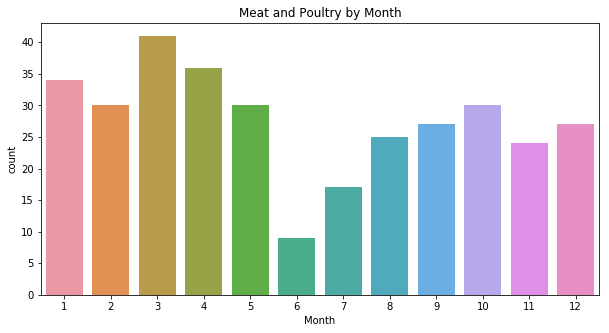

In [48]:
fig, ax = plt.subplots(figsize=(10,5)) #visualization
sns.countplot(x='Month',
              data=df9)
plt.title('Meat and Poultry by Month')
plt.show()

In [49]:
formula = 'Quantity ~ C(Month)'
lm = smf.ols(formula, df9).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq     df        F    PR(>F)
C(Month)    5293.456878   11.0  1.32483  0.209122
Residual  115508.449182  318.0      NaN       NaN


## Results 
#### Our F statistic came out to be greater than our alpha in all cases. Hence, we failed to reject the null hypothesis in all cases. 

## Conclusions 
**- All discounts have approximately the same effect on order quantity with the exception of the 10% discount.**<br>

**- There were less quantities of all products ordered during the month of June but the quantity dips were not significant enough to reject our null hypothesis**<br>

## Recommendations
**- From the data, I would recommend getting rid of the 10% discounts. However, with more time I would run some further analysis to determine why the 10% does not have the same effect on quantities purchased as the other discounts. It seems a bit odd that 5% would have an effect but 10% would not.**<br>

**- Although we failed to reject the null hypothesis for the categories questions, the exploratory analysis did seem to show a dip in sales after April. Furthur inquiry might provide some insight.** 
